Linear Regression - MSE: 0.0008556384140245147, R²: 0.9890864087005483
Random Forest - MSE: 0.0008151410037231684, R²: 0.9896029495400792
XGBoost - MSE: 0.002301693838262856, R²: 0.9706421013414818


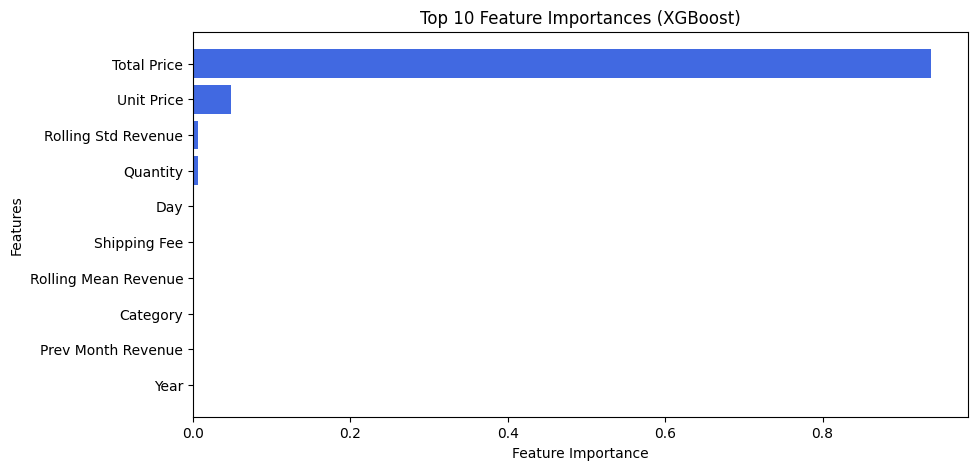

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Dataset
file_path = "SalesData.csv"
df = pd.read_csv(file_path)

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Drop unnecessary columns (like Customer ID, which cannot be used for predictions)
df.drop(columns=['Customer ID'], inplace=True, errors='ignore')

# Fill Missing Values
df.fillna({
    'Region': 'Unknown',
    'Shipping Status': 'Unknown',
    'Age': df['Age'].median()
}, inplace=True)

# Generate Time-based Features
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['Weekday'] = df['Order Date'].dt.day_name()
df['Quarter'] = df['Order Date'].dt.quarter
df['Is Weekend'] = df['Weekday'].isin(['Saturday', 'Sunday']).astype(int)

# Calculate Revenue
df['Total Revenue'] = df['Quantity'] * df['Unit Price']

# Remove Outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'Quantity')
df = remove_outliers(df, 'Total Revenue')

# Normalize Numerical Columns
scaler = MinMaxScaler()
numeric_cols = ['Unit Price', 'Quantity', 'Total Revenue']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Encode Categorical Columns
label_encoder = LabelEncoder()
for col in ['Category', 'Region', 'Shipping Status']:  # List all categorical columns
    df[col] = label_encoder.fit_transform(df[col])

# Create Lag Features for Time-Series
df['Prev Month Revenue'] = df['Total Revenue'].shift(30)
df['Rolling Mean Revenue'] = df['Total Revenue'].rolling(window=7).mean()
df['Rolling Std Revenue'] = df['Total Revenue'].rolling(window=7).std()

# Drop rows with NaN values created by shifting
df.dropna(inplace=True)

# Define Features and Target Variable
X = df.drop(columns=['Order Date', 'Weekday', 'Total Revenue'])
y = df['Total Revenue']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure only numeric values in training data
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluate Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr}, R²: {r2_lr}")

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf}, R²: {r2_rf}")

# Train XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    reg_lambda=5,
    reg_alpha=3,
    random_state=42
)

xgb_model.fit(X_train, np.log1p(y_train))  # Log transform target
y_pred_xgb = np.expm1(xgb_model.predict(X_test))  # Reverse log transform

# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MSE: {mse_xgb}, R²: {r2_xgb}")

# Save Best Model
joblib.dump(xgb_model, "xgboost_sales_model.pkl")

# Feature Importance Visualization
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = X_train.columns[sorted_idx]

plt.figure(figsize=(10, 5))
plt.barh(sorted_features[:10], feature_importance[sorted_idx][:10], color="royalblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = X_train.columns[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(sorted_features[:10], feature_importance[sorted_idx][:10], color="royalblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import joblib
joblib.dump(xgb_model, "xgboost_sales_model.pkl")

In [6]:
import streamlit as st
import joblib

# Load trained model
model = joblib.load("xgboost_sales_model.pkl")

# Load scaler if used during training
scaler = joblib.load("scaler.pkl")  # Ensure this file exists in GitHub

# Load Label Encoder
label_encoder = joblib.load("label_encoder.pkl")  # Ensure this exists

# Streamlit UI
st.title("Sales Revenue Prediction App")
st.write("Enter the values to predict revenue.")

st.sidebar.header("Enter Product Details")

unit_price = st.sidebar.number_input("Unit Price ($)", min_value=1.0, format="%.2f")
quantity = st.sidebar.number_input("Quantity", min_value=1)
shipping_fee = st.sidebar.number_input("Shipping Fee ($)", min_value=0.0, format="%.2f")

category = st.sidebar.selectbox("Product Category", ["Electronics", "Clothing", "Home", "Beauty", "Sports"])
region = st.sidebar.selectbox("Region", ["North", "South", "East", "West"])
shipping_status = st.sidebar.selectbox("Shipping Status", ["Pending", "Shipped", "Delivered"])

# Encode categorical variables before creating input_data
category_encoded = label_encoder.fit_transform([category])[0]
region_encoded = label_encoder.fit_transform([region])[0]
shipping_status_encoded = label_encoder.fit_transform([shipping_status])[0]

# Button for prediction
if st.sidebar.button("Predict Revenue"):
    st.write("✅ Button Clicked!")  # Debugging

    # Prepare input data
    input_data = pd.DataFrame([[unit_price, quantity, shipping_fee, category_encoded, region_encoded, shipping_status_encoded]],
                              columns=["Unit Price", "Quantity", "Shipping Fee", "Category", "Region", "Shipping Status"])

    # Apply feature scaling
    input_data_scaled = scaler.transform(input_data)

    # Make prediction
    prediction = np.expm1(model.predict(input_data_scaled))  # Reverse log transformation if applied

    # Display result
    st.success(f"💰 Predicted Revenue: **${prediction[0]:,.2f}**")


ModuleNotFoundError: No module named 'streamlit'